<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 


<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

## Chatbot: catégorisations et prévisions des réponses aux questions

# Text Mining et Catégorisation de Produits en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

## Introduction

Il s'agit de prévoir la réponse à une question à partir de son sujet. Seule la catégorie principale (1er niveau) est prédite mais nous pourrons essayer d'affiner par la suite. L'objectif est plutôt de comparer les performances des méthodes et technologies en fonction de la taille de la base d'apprentissage ainsi que d'illustrer sur un exemple complexe le prétraitement de données textuelles. La stratégie de sous ou sur échantillonnage des catégories qui permet d'améliorer la prévision va être mise en oeuvre. Nous allons essayer différentes techniques d'échantillonnage comme le regroupement de plusieurs catégories en fonction de leur points communs ou selon leur taille puis nous essayerons de mettre en place un mélange de upsampling et de downsampling.
* Nous allons réduire l'échantillon réduit en le séparant en 2 parties: apprentissage et validation. 
* Les données textuelles sont  nettoyées, racinisées, vectorisées avant modélisation.
* Trois modélisations sont estimées: logistique, arbre, forêt aléatoire.
* Optimiser l'erreur en faisant varier différents paramètres: types et paramètres de vectorisation (TF-IDF), paramètres de la régression logistique (pénalisation l1) et de la forêt aléatoire (nombre d'arbres et nombre de variables aléatoire).

Exécuter finalement le code pour différentes tailles (paramètre  `tauxTot` ci-dessous) de l'échantillon d'apprentissage et comparer les qualités de prévision obtenues. 


In [41]:
#Importation des librairies utilisées
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import collections
import itertools
import csv
import warnings

from sklearn.cross_validation import train_test_split

In [42]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

## 1. Importation des données
Définition du répertoir de travail, des noms des différents fichiers utilisés et des variables globales.


In [43]:
# Répertoire de travail
DATA_DIR = "C:/Users/emma/Documents/ecole/insa/projet chabot/"

# Nom des fichiers
training_reduit_path = DATA_DIR + "INSA_wefight_data_clean.csv"
# Variable Globale
HEADER_TEST = ['Question','Intent','BlockId', 'Action']
HEADER_TRAIN =['Question','Intent','BlockId', 'Action']

In [44]:
## Si nécessaire (première exécution) chargement de nltk, librairie pour la suppression 
## des mots d'arrêt et la racinisation
## nltk.download()

   ### Read & Split Dataset
   Fonction permettant de lire le fichier d'apprentissage et de créer deux DataFrame Pandas, un pour l'apprentissage, l'autre pour la validation.
   La première méthode créée un DataFrame en lisant entièrement le fichier. Puis elle scinde le DataFrame en deux  grâce à la fonction dédiée de sklearn. 

In [45]:
def split_dataset(input_path, nb_line, tauxValid,columns):
    time_start = time.time()
    data_all = pd.read_csv(input_path,sep=",",names=columns,nrows=nb_line) #cree data frame
    data_all = data_all.fillna("") #remplace les na par " "
    data_train, data_valid = train_test_split(data_all, test_size = tauxValid) # Split arrays or matrices into random train and test subsets
    time_end = time.time()
    print("Split Takes %d s" %(time_end-time_start))
    return data_train, data_valid

nb_line=20000  # part totale extraite du fichier initial ici déjà réduit
tauxValid=0.10 # part totale extraite du fichier initial ici déjà réduit
data_train, data_valid = split_dataset(training_reduit_path, nb_line, tauxValid, HEADER_TRAIN)
# Cette ligne permet de visualiser les 5 premières lignes de la DataFrame 
data_train.head(5)

Split Takes 0 s


,Question,Intent,BlockId,Action
1585,Quels sont les effets secondaires de la radiot...,#2-58_QVDP_RadioT_Eff,59843d91e4b03f0d13119537,wiki_cancer
1011,pourquoi la chimiothérapie entraine une chute ...,#2-36_QVDP_Alopecie_Pourquoi,5984243ae4b03f0d12766ac7,wiki_cancer
802,où trouver des vitamines,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer
726,Curcuma pipérine c est celui là que je prends,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer
414,dangers de l'allaitement ppndbnt un traitement,#2-115_QVDP_Grossesse_Allaitement,598d6f5fe4b03f0d40c062d3,wiki_cancer


## 2. Nettoyage des données
Afin de limiter la dimension de l'espace des variables ou *features*, tout en conservant les informations essentielles, il est nécessaire de nettoyer les données en appliquant plusieurs étapes:
* Chaque mot est écrit en minuscule.
* Les termes numériques, de ponctuation et autres symboles sont supprimés.
* 155 mots-courants, et donc non informatifs, de la langue française sont supprimés (STOPWORDS). Ex: le, la, du, alors, etc...
* Chaque mot est "racinisé", via la fonction `STEMMER.stem` de la librairie nltk. La racinisation transforme un mot en son radical ou sa racine. Par exemple, les mots: cheval, chevaux, chevalier, chevalerie, chevaucher sont tous remplacés par "cheva".

### Importation des librairies et fichier pour le nettoyage des données.

In [46]:
# Librairies 
from bs4 import BeautifulSoup #Nettoyage d'HTML
import re # Regex
import nltk # Nettoyage des données

## listes de mots à supprimer dans la description des produits
## Depuis NLTK
nltk_stopwords = nltk.corpus.stopwords.words('french') 
## Depuis Un fichier externe.
lucene_stopwords = [unicode(w, "utf-8") for w in open(DATA_DIR+"lucene_stopwords.txt").read().split(",")] #En local

## Union des deux fichiers de stopwords 
stopwords = list(set(nltk_stopwords).union(set(lucene_stopwords)))

## Fonction de setmming de stemming permettant la racinisation
stemmer=nltk.stem.SnowballStemmer('french')

### Fonction de nettoyage de texte
Fonction qui prend en intrée un texte et retourne le texte nettoyé en appliquant successivement les étapes suivantes: Nettoyage des données HTML, conversion en texte minuscule, encodage uniforme, suppression des caractéres non alpha numérique (ponctuations), suppression des stopwords, racinisation de chaque mot individuellement.

In [47]:
# remarque
#'a b c'.split()
#str.split('a b c')
# both return ['a', 'b', 'c']

In [48]:
# Fonction clean générale
def clean_txt(txt):
    ### remove html stuff
    txt = BeautifulSoup(txt,"html.parser",from_encoding='utf-8').get_text() #nettoyage donnee html
    ### lower case
    txt = txt.lower()
    ### special escaping character '...'
    txt = txt.replace(u'\u2026','.')
    txt = txt.replace(u'\u00a0',' ')
    ### remove accent btw
    txt = unicodedata.normalize('NFD', txt).encode('ascii', 'ignore')
    ###txt = unidecode(txt)
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove french stop words
    tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
    ### french stemming
    tokens = [stemmer.stem(token) for token in tokens]
    #Stemmers remove morphological affixes from words, leaving only the word stem
    ### tokens = stemmer.stemWords(tokens)
    return ' '.join(tokens)
    #join() returns a string in which the string elements of sequence have been joined by str separator.

def clean_marque(txt):
    txt = re.sub('[^a-zA-Z0-9]', '_', txt).lower()
    return txt

#### Wordcloud sur les données non nettoyé

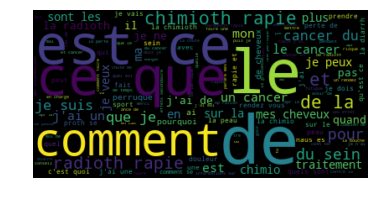

In [49]:
#on enregistre le contenu de la colonne Question dans un fichier csv
#on fait ensuite un wordcloud sur toutes les donnees
description2 = data_train["Question"]
description2.to_csv('Question.csv', sep = ',')


#from os import path

from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open(path.join(DATA_DIR, 'Question.csv')).read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=80).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

 Nous avons effectué un wordcloud sur l'ensemble de nos données non nettoyées. Nous remarquons que les mots les plus importants sont des déterminants comme "le", "ce", "la", "de" ou des mots caractérisants les questions dans la langue française comme "que", "comment" ou le verbe être. Ces mots ne nous permettent pas de caractériser un domaine relatif à une question. Nous allons donc nettoyer nos données afin de garder uniquement les mots censés être discriminants.

### Nettoyage des DataFrames
Applique le nettoyage sur toutes les lignes de la DataFrame

In [50]:
# fonction de nettoyage du fichier(stemming et liste de mots à supprimer)
def clean_df(input_data, column_names= ['Question','Intent','BlockId', 'Action']):
    #Test if columns entry match columns names of input data
    column_names_diff= set(column_names).difference(set(input_data.columns))
    #set.difference   new set with elements in column_names but not in input_data.columns
    
    if column_names_diff: #rentre dans la boucle si column_names différent zero
        # warning = exception
        warnings.warn("Column(s) '"+", ".join(list(column_names_diff)) +"' do(es) not match columns of input data", Warning)
        
    nb_line = input_data.shape[0]
    print("Start Clean %d lines" %nb_line)
    
    # Cleaning start for each columns
    time_start = time.time()
    clean_list=[]
    for column_name in column_names:
        column = input_data[column_name].values
        if column_name == "Question":
            array_clean = np.array(map(clean_txt,column))
            
        elif column_name == "Intent":
            array_clean = np.asarray(input_data['Intent']) #on recopie telle quelle la colonne intent  
            
        else:
            array_clean = np.array(map(clean_marque,column))
            #applies a function to all the items in an input_list
            #map(function_to_apply, list_of_inputs)
        clean_list.append(array_clean)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    
    #Convert list to DataFrame
    array_clean = np.array(clean_list).T
    data_clean = pd.DataFrame(array_clean, columns = column_names)
    return data_clean

In [51]:
# Take approximately 2 minutes fors 100.000 rows
data_valid_clean = clean_df(data_valid)
data_train_clean = clean_df(data_train)

Start Clean 502 lines
Cleaning time: 0 secondes
Start Clean 4511 lines
Cleaning time: 5 secondes


Affiche les 5 premières lignes de la DataFrame d'apprentissage après nettoyage.

In [52]:
#info sur les données
data_train_clean.info()
data_train_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4511 entries, 0 to 4510
Data columns (total 4 columns):
Question    4511 non-null object
Intent      4511 non-null object
BlockId     4511 non-null object
Action      4511 non-null object
dtypes: object(4)
memory usage: 141.0+ KB


,Question,Intent,BlockId,Action
0,effet secondair radiotherap,#2-58_QVDP_RadioT_Eff,59843d91e4b03f0d13119537,wiki_cancer
1,chimiotherap entrain chut cheveux,#2-36_QVDP_Alopecie_Pourquoi,5984243ae4b03f0d12766ac7,wiki_cancer
2,trouv vitamin,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer
3,curcum piperin prend,#2-130_QVDP_Alimentation,5991c543e4b0b2045b0c568f,wiki_cancer
4,danger allait ppndbnt trait,#2-115_QVDP_Grossesse_Allaitement,598d6f5fe4b03f0d40c062d3,wiki_cancer


Nous remarquons d'après l'affichage des 5 premières lignes après nettoyage que les mots importants des données avant nettoyage ont disparu. En effet, il semble qu'il reste uniquement des mots caractérisants notre sujet et nos questions. De plus ces mots ont été racinisés afin de réunir des familles de mots. Nous allons maintenant appliquer de nouveau un worcloud sur l'ensemble de nos données nettoyées.

In [53]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Action"].value_counts())
print("nb Action differente",(data_train["Action"].value_counts()).shape)

wiki_cancer                                          4244
                                                       88
conversation_rappelRendezVous                          80
conversation_rappelRead                                31
conversation_rappelUpdate2                             15
conversation_FichePatientRead                          11
wiki_cancer#                                           11
conversation_FichePatientUpdate                         7
conversation_hist                                       5
conversation_FichePatientWrite:age                      4
conversation_FichePatientWrite:doseTraitement           4
conversation_rappelUpdate                               3
conversation_FichePatientWrite:typeTraitement           2
conversation_FichePatientWrite:rappels                  2
conversation_FichePatientWrite:nomTraitement            1
conversation_FichePatientWrite:recevoirTemoignage       1
conversation_FichePatientWrite:newsletter               1
conversation_F

Nous comptons ici le nombre d'actions différentes que nous pouvons réaliser suite à une question. Nous avons 21 actions possibles. Chaque action contient elle même un nombre différent de sous catégorie liées aux domaines des questions.

In [54]:
# comptage u nbre d'occurence de categorie puis comptage du nbre de categorie differente
print(data_train["Intent"].value_counts())
print("nb intent differente",(data_train["Intent"].value_counts()).shape)

#6-49_TRTEINS_Peau                             187
#6-97_TRTEINS_Nausees_Vomissements             130
#6-92_TRTEINS_Diarrhee                         123
#6-53_TRTEINS_Aphtes                           113
#2-130_QVDP_Alimentation                       113
#2-36_QVDP_Alopecie_Pourquoi                   103
#6-60_TRTEINS_PAC                               99
#6-90_TRTEINS_Mauvais_Gout                      99
#6-98_TRTEINS_EI_Frequents                      97
#9-2_Informations_cancer                        94
#6-18_TRTEINS_Radiotherapie                     86
#6-57_TRTEINS_Yeux_Secs                         84
#2-64-0_QVDP_Fatigue                            83
conversation_rappel_rendezvous                  80
#2-45_QVDP_Alopecie_Perruque                    78
#2-55_QVDP_Douleur                              75
#2-96_QVDP_Social_Priseencharge                 74
#6-96_TRTEINS_Perte_Poids                       72
#6-1_TRTEINS_Chimiotherapie                     72
#6-24_TRTEINS_hormonotherapie  

Nous comptons et affichons ici le nombre de catégories que nous avons. Nous avons 146 catégories chacune liée à un sujet spécifique. Chaque question est liée à la catégorie qui lui correspond le plus et lui donnant ainsi la meilleure réponse possible.

###### On enregistre le contenu de la colonne Question dans un fichier csv puis on fait ensuite un wordcloud sur toutes les donnees

In [55]:
description = data_train_clean["Question"]
description.to_csv('Question.csv', sep = ',')

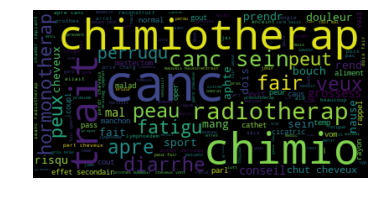

In [56]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open(path.join(DATA_DIR, 'Question.csv')).read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

Nous avons effectué un wordcloud sur l'ensemble de nos données nettoyées. Nous remarquons que les mots les plus importants sont "chimiotherapie","cancer","faire","radiotherapie","traitement" et "sein". Ces mots correspondent à notre domaine il est donc logique de les voir apparaître souvent. Cependant, nous pouvons nous demander s'ils apparaissent souvent dans toutes les catégories ou seulement dans certaines catégories ? Nous allons donc effectuer un wordcloud sur une ou plusieurs catégories en particulier afin d'identifier les mots discriminants relatifs à cette catégorie.

In [57]:
# tri par catégorie, on a un data frame pour une catégorie
df = data_train_clean[data_train_clean['Intent'] == '#6-49_TRTEINS_Peau']

###### On enregistre le contenu de la colonne Intent dans un fichier csv puis on fait ensuite un wordcloud sur une categorie, ici la plus grosse qui est #6-49_TRTEINS_Peau

In [58]:
description2 = df
description2.to_csv('Intent.csv', sep = ',')

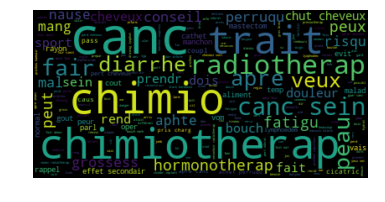

In [60]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open(path.join(DATA_DIR, 'Question.csv')).read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

Nous avons ici effectué le wordcloud sur la catégorie traitement de la peau qui correspond à la plus grosse catégorie de notre base de données. Nous retrouvons les mots "cancer", "chimiothérapie", "cancer sein", "radiothérapie" et "traitement". Cependant de nouveaux mots apparaissent tels que "perruque", "homonothérapie", "diarrhée" et "peau". Nous pouvons alors nous poser les questions suivantes devrions nous rajouter des stopwords tels que "peux", "veux", "faire" etc... De plus il apparait que les mots les plus présents dans le document soient également les mêmes que ceux présents dans la catégorie. Pour évaluer l'impact discriminant de ces mots, nous allons essayer de regrouper en métacatégories nos sous catégories afin de n'avoir plus que 1 document par catégorie. Nous voulouns voir si le mot "cancer" est discriminant pour la catégorie traitement de la peau. Pour cela nous allons regrouper toutes les questions présentes dans cette catégorie en 1 seule question. Nous calculerons ensuite le TF-IDF sur ces nouvelles catégories et nous afficherons les nouveaux wordcloud obtenus. 

In [64]:
# tri par catégorie, on a un data frame pour une catégorie
df = data_train_clean[data_train_clean['Intent'] == '#2-130_QVDP_Alimentation']

In [65]:
description2 = df
description2.to_csv('Intent.csv', sep = ',')

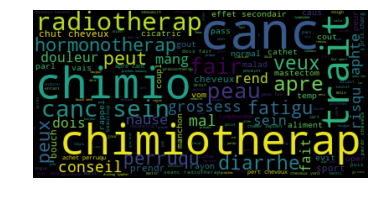

In [66]:
from os import path
from wordcloud import WordCloud

#d = path.dirname()

# Read the whole text.
#text = open(path.join(d, 'constitution.txt')).read()
text = open(path.join(DATA_DIR, 'Question.csv')).read()
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
#import matplotlib.pyplot as plt
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()